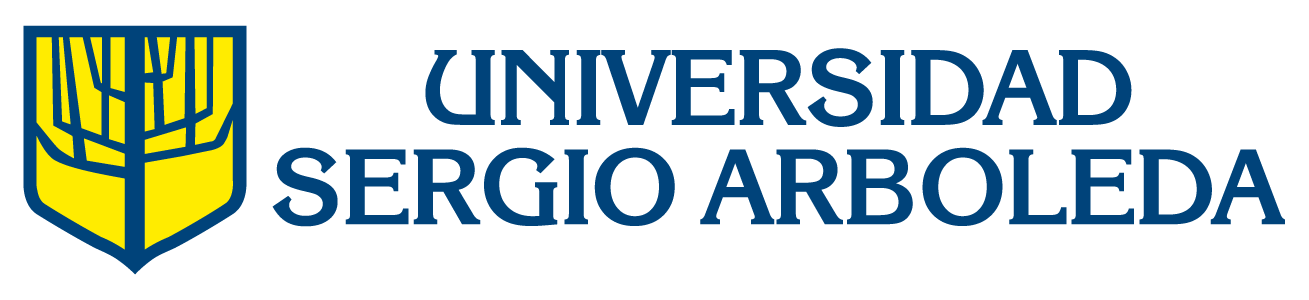


---




**Proyecto Procesamiento Imágenes**

**Autores:**  

* Carlos Bermúdez
* Miguel Thomas


**Programa acádemico:**  

* Ciencias de la computación e Inteligencia Artificial

**Materia:**   
* Procesamiento de Imagenes

In [1396]:
import cv2
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image
import requests

# Carga de datos

In [1397]:
def read_imgs(path):
    '''
    Lee todas las imágenes en formato PGM (Portable GrayMap) de un directorio dado.

    Parametros:
    - path: La ruta al directorio que contiene las imágenes.

    Retorna:
    - imgs: Una lista de matrices numpy representando las imágenes leídas.
    
    La función recorre el directorio especificado y busca archivos con extensión ".pgm".
    Por cada archivo encontrado, carga la imagen utilizando OpenCV y la añade a una lista.
    Finalmente, retorna la lista de imágenes cargadas.
    '''
    imgs = []
    for img in os.listdir(path):
        base, extension = os.path.splitext(img)
        if extension == '.pgm':
            path_img = os.path.join(path,img)

            imgs.append(cv2.imread(path_img,cv2.IMREAD_GRAYSCALE))

    return np.array(imgs)
lib_path = 'imgs-mamografias'

imgs = read_imgs(lib_path)


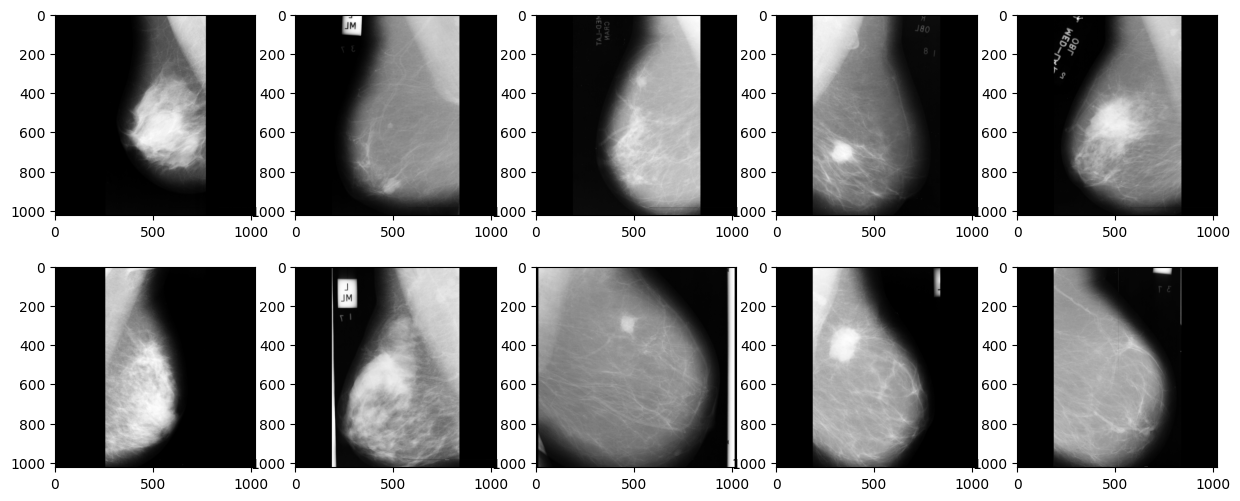

In [1398]:
def show_imgs(imgs):
    '''
    Muestra una lista de imágenes en una matriz de 2 filas y 5 columnas utilizando Matplotlib.

    Parametros:
    - imgs: Una lista de matrices numpy representando las imágenes a mostrar.
    
    Esta función crea una figura con subtramas dispuestas en una matriz de 2x5.
    Recorre la lista de imágenes y las muestra en estas subtramas. Si hay menos de
    10 imágenes en la lista, los espacios restantes en la matriz quedan en blanco.
    '''
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))

    for i in range(2):
        for j in range(5):
            if i*5 + j < len(imgs):
                axes[i, j].imshow(imgs[i*5 + j],cmap = 'gray')
                #axes[i, j].axis('off')

    plt.show()
    
show_imgs(imgs)

In [1399]:
print("Cantidad images" ,len(imgs))
print("Tamaño de la lista: ",imgs.shape)

Cantidad images 10
Tamaño de la lista:  (10, 1024, 1024)


In [1400]:
def resize_images(images, width=225, height=225):
    '''
    Redimensiona una lista de imágenes a las dimensiones especificadas.

    Parametros:
    - images: Lista de imágenes en forma de matrices numpy.
    - width: Ancho deseado para las imágenes redimensionadas.
    - height: Altura deseada para las imágenes redimensionadas.

    Retorna:
    - np.array: Lista de imágenes redimensionadas.
    
    Esta función itera sobre cada imagen en la lista y utiliza la función `cv2.resize`
    para cambiar su tamaño al ancho y altura especificados. La función de interpolación
    utilizada es INTER_LINEAR, que es adecuada para la mayoría de los casos de uso.
    '''
    resized_images = []
    for img in images:
        # Ajustar el tamaño de la imagen a las dimensiones especificadas
        resized_img = cv2.resize(img, (width, height), interpolation=cv2.INTER_LINEAR)
        resized_images.append(resized_img)
        
    return np.array(resized_images)

imgs = resize_images(imgs)

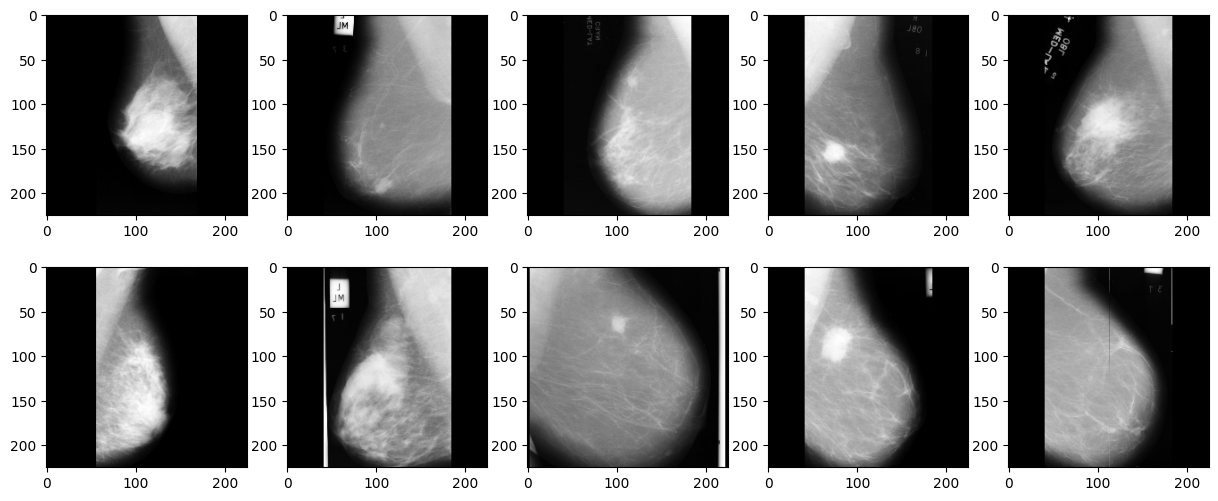

In [1401]:
show_imgs(imgs)

# Mejorar la calidad: Reducir el ruido y mejorar el contraste

## Reducir el ruido

In [1402]:
def apply_gaussian_filter(imgs,kernel_Size=(5,5),sigmaX=0,simgaY=0):
    """
    Aplica un filtro gaussiano a una lista de imágenes para suavizarlas.
    
    Parámetros:
        imgs (list of np.array): Lista de imágenes en formato NumPy array, donde cada imagen 
                                 debe estar en formato de escala de grises o BGR (no binarizada).
        kernel_size (tuple of int, int): Tamaño del kernel para el filtro gaussiano. Debe ser 
                                         un número impar. El valor predeterminado es (5, 5).
        sigmaX (float): Desviación estándar en la dirección X del kernel gaussiano. Si se pasa 
                        cero, se calcula automáticamente basado en el tamaño del kernel.
        sigmaY (float): Desviación estándar en la dirección Y del kernel gaussiano. Si se pasa
                        cero es igual a sigmaX.

    Retorna:
        np.array: Array de NumPy que contiene las imágenes suavizadas.
        
    Esta función recibe una lista de imágenes y aplica un filtro gaussiano a cada una de ellas.
    El filtro gaussiano ayuda a reducir el ruido y los detalles de la imagen. Los parámetros del
    filtro, como el tamaño del kernel y las desviaciones estándar en las direcciones x e y, 
    pueden ser ajustados.
    """
    imgs_gaussian = []
    for img in imgs:
        img_gaussian = cv2.GaussianBlur(img,kernel_Size, sigmaX,simgaY )
        imgs_gaussian.append(img_gaussian)
    
    return np.array(imgs_gaussian)


### Filtro Gaussiano con SigmaX = SigmaY

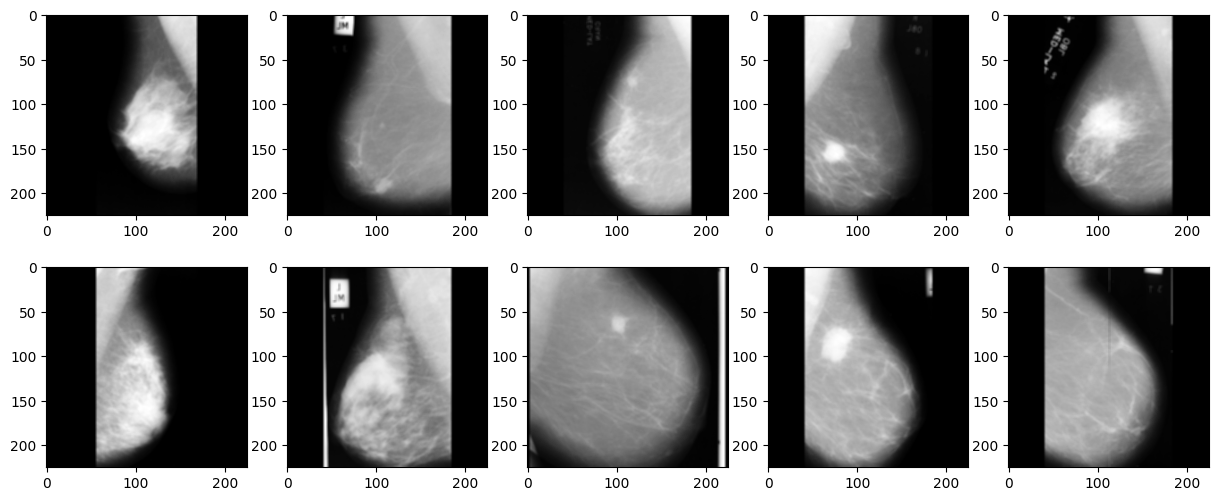

In [1403]:
# Imagenes con sigma igual Alto
imgs_transform = imgs.copy()
imgs_transform = apply_gaussian_filter(imgs_transform,(3,3),sigmaX=3,simgaY=3)
show_imgs(imgs_transform)

## Mejorar el contraste

In [1404]:
def apply_expan_contrast(imgs):
    """
    Aplica expansión del contraste a una lista de imágenes.
    
    Parámetros:
        imgs (list of numpy.ndarray): Lista de imágenes en formato de array de NumPy. 

    Retorna:
        np.array: Array de NumPy conteniendo las imágenes con el contraste expandido.
                       
    Este método mejora el contraste de las imágenes ajustando sus valores de intensidad
    al rango completo de los valores posibles dentro del tipo de datos de la imagen, 
    normalmente [0, 255] para imágenes de 8 bits.
    """
    imgs_contrast = []
    for img in imgs:
        I_min = np.min(img)
        I_max = np.max(img)
        a = 255.0 / (I_max - I_min)
        b = -a * I_min

        imagen_contrastada = (a * img + b).clip(0, 255).astype(np.uint8)
        imgs_contrast.append(imagen_contrastada)
    
    return np.array(imgs_contrast)

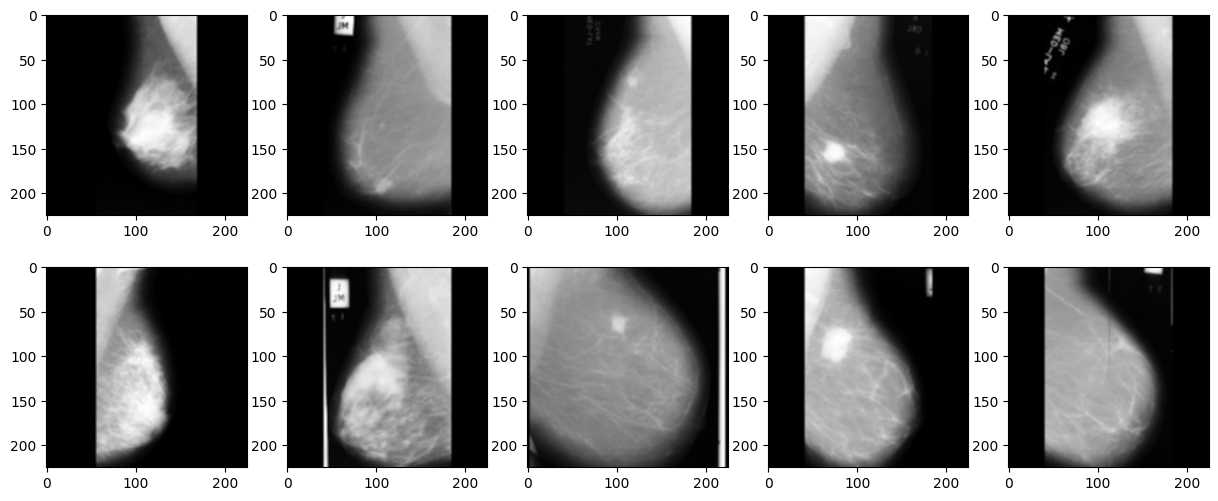

In [1405]:
imgs_contrast = apply_expan_contrast(imgs_transform)
show_imgs(imgs_contrast)

In [1406]:
imgs_transform = imgs_contrast

# Realzar Caracteristicas: Bordes y Transformaciones de intensidad

#### Sobel:  Resaltar los bordes de la imagen

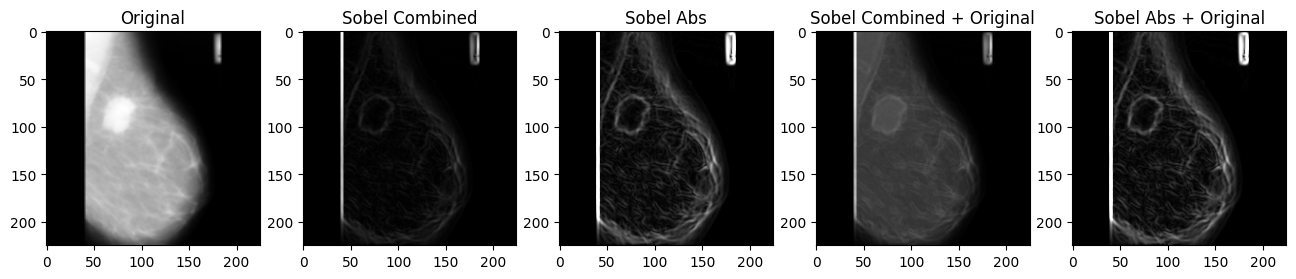

In [1407]:
# Calcular el gradiente en dirección x (horizontal)
sobelx = cv2.Sobel(imgs_transform[8], cv2.CV_64F, 1, 0, ksize=3)

# Calcular el gradiente en dirección y (vertical)
sobely = cv2.Sobel(imgs_transform[8], cv2.CV_64F, 0, 1, ksize=3)

# Combinar ambos gradientes
sobel_combined = cv2.magnitude(sobelx, sobely)

# Mostrar los resultados
plt.figure(figsize=(16, 7))
plt.subplot(1, 5, 1), plt.imshow(imgs_transform[8], cmap='gray'), plt.title('Original')
plt.subplot(1, 5, 2), plt.imshow(sobel_combined, cmap='gray'), plt.title('Sobel Combined')
plt.subplot(1, 5, 3), plt.imshow( cv2.convertScaleAbs(sobel_combined), cmap='gray'), plt.title('Sobel Abs')
plt.subplot(1, 5, 4), plt.imshow(sobel_combined+imgs_transform[8], cmap='gray'), plt.title('Sobel Combined + Original')
plt.subplot(1, 5, 5), plt.imshow( cv2.convertScaleAbs(sobel_combined), cmap='gray'), plt.title('Sobel Abs + Original')
plt.show()

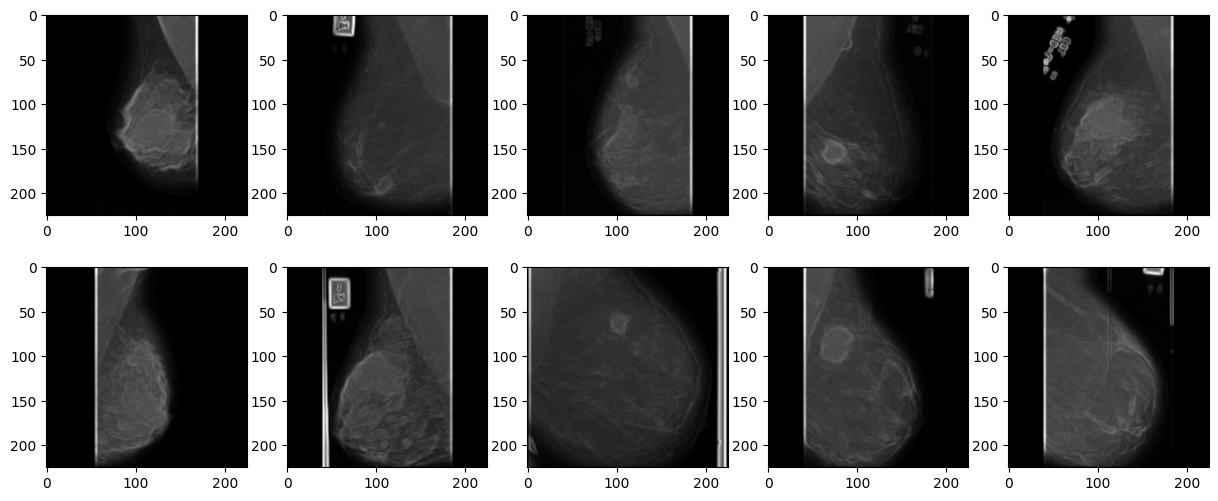

In [1408]:
def apply_sobel_filter(imgs):
    """
    Aplica el filtro de Sobel a una lista de imágenes para detectar bordes. Esta función calcula
    los gradientes de la imagen en las direcciones x e y, combina estos gradientes para destacar
    los bordes en las imágenes, luego suma las imagenes originales para resaltar los bordes.

    Parámetros:
        imgs (list of numpy.ndarray): Lista de imágenes en formato de array de NumPy, donde cada 
                                      imagen debe estar en formato de escala de grises o BGR.

    Retorna:
        numpy.ndarray: Array de NumPy que contiene las imágenes procesadas con el filtro de Sobel 
                       combinado con las imágenes originales en la lista.
    """
    imgs_sobel = []
    for img in imgs:
        sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)

        # Calcular el gradiente en dirección y (vertical)
        sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)

        # Combinar ambos gradientes
        sobel_combined = cv2.magnitude(sobelx, sobely)
        #sobel_abs = cv2.convertScaleAbs(sobel_combined)
        imgs_sobel.append(sobel_combined)
        
    return np.array(imgs_sobel+imgs)

imgs_sobel = apply_sobel_filter(imgs_transform)
show_imgs(imgs_sobel)

## Transformacion de intensidad

### Filtro Logaritmico: Mejorar la visibilidad de detalles finos

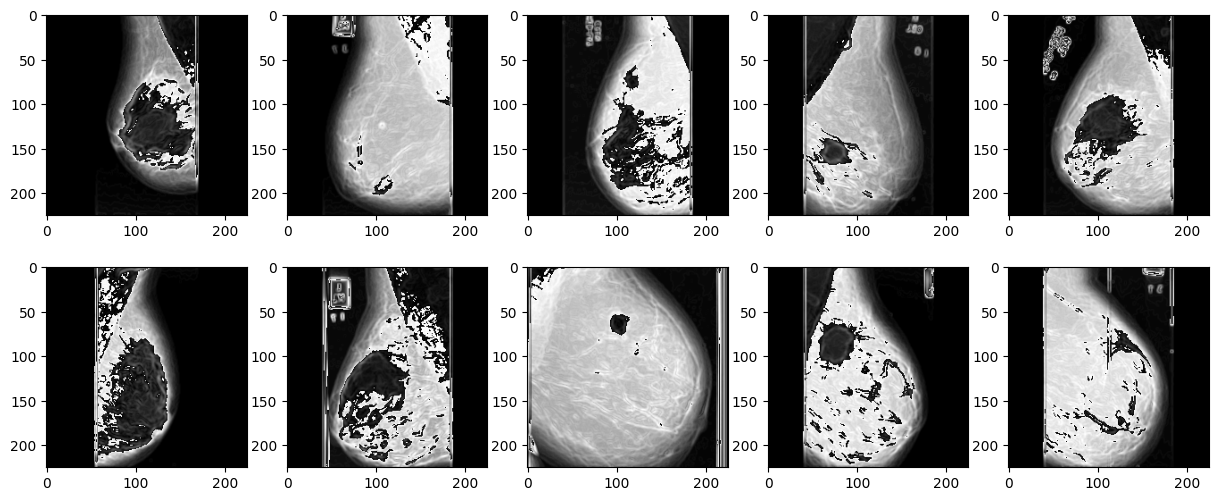

In [1409]:
def apply_logarit_filter(imgs, c=2):
    """
    Aplica un filtro logarítmico a una lista de imágenes para realzar los detalles en las áreas oscuras.
    
    Parámetros:
        imgs (list of np.array): Lista de imágenes en formato de array de NumPy. Cada imagen debe estar en 
                                 formato de escala de grises y debe ser de tipo uint8.
        c (int or float): Factor de escala que ajusta la intensidad del efecto del filtro logarítmico. Un valor 
                          más alto aumenta el efecto del logaritmo, realzando más los detalles en áreas oscuras.

    Retorna:
        np.array: Array de imágenes en NumPy que han sido procesadas con el filtro logarítmico. Las imágenes 
                  retornadas están en el mismo formato y tipo de datos que las imágenes de entrada.
                  
    Esta función transforma los valores de píxeles de las imágenes según una transformación logarítmica, 
    lo que ayuda a mejorar la visibilidad de los detalles en las áreas más oscuras sin alterar significativamente 
    las áreas más brillantes. La transformación se ajusta utilizando un factor de escala `c`.
    """
    imgs_log = []
    for image in imgs:
        img_normalized = image / 255.0
        img_transformed = c * np.log(1 + img_normalized)
        imgs_log.append((img_transformed * 255).astype("uint8"))
    
    return np.array(imgs_log)
    
imgs_log = apply_logarit_filter(imgs_sobel,1.65)     
show_imgs(imgs_log)



# Morfologias: Eliminar Puntos negros

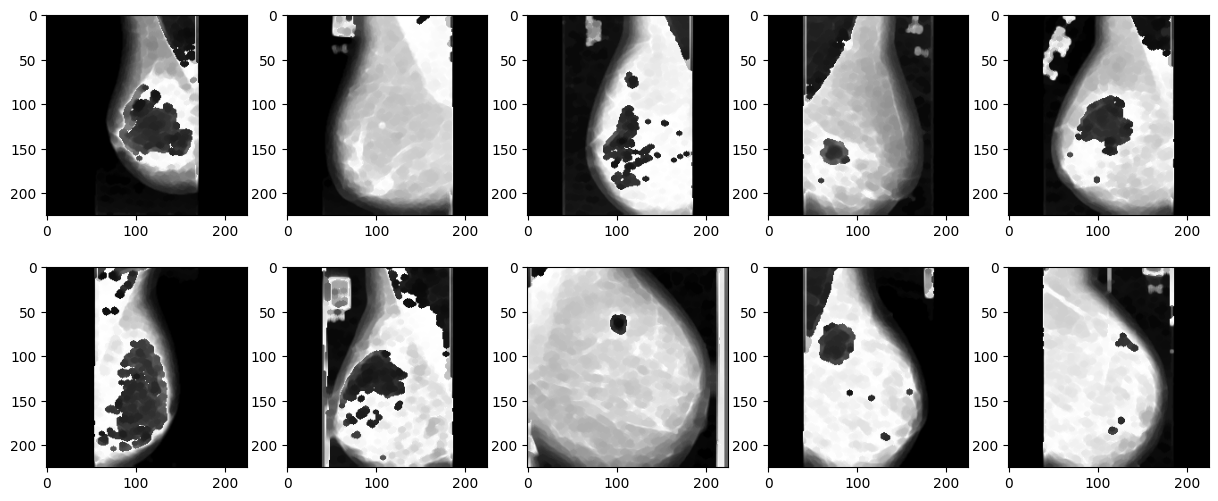

In [1410]:
def apply_close_morfology(imgs,kernel_size=(5,5)):
    """
    Aplica el cierre morfológico a una lista de imágenes utilizando un kernel elíptico.

    Parámetros:
        imgs (list of np.array): Lista de imágenes en formato de array de NumPy. Cada imagen debe estar 
                                 en formato adecuado para procesamiento morfológico, típicamente en escala de grises.

    Retorna:
        np.array: Array de NumPy que contiene las imágenes después de aplicar el cierre morfológico.
                  
    Esta función transforma cada imagen en la lista aplicando una operación de cierre morfológico,
    que es útil para cerrar pequeños huecos y eliminar pequeños objetos negros dentro de las regiones más grandes.
    La operación de cierre utiliza un kernel elíptico de tamaño 7x7 para realizar la dilatación seguida de la erosión.
    """
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,kernel_size)
    imgs_open = []
    for img in imgs:
        # Aplicar apertura para eliminar ruido
        opening = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
        imgs_open.append(opening)
    return np.array(imgs_open)


imgs_close = apply_close_morfology(imgs_log,(7,7))
show_imgs(imgs_close)

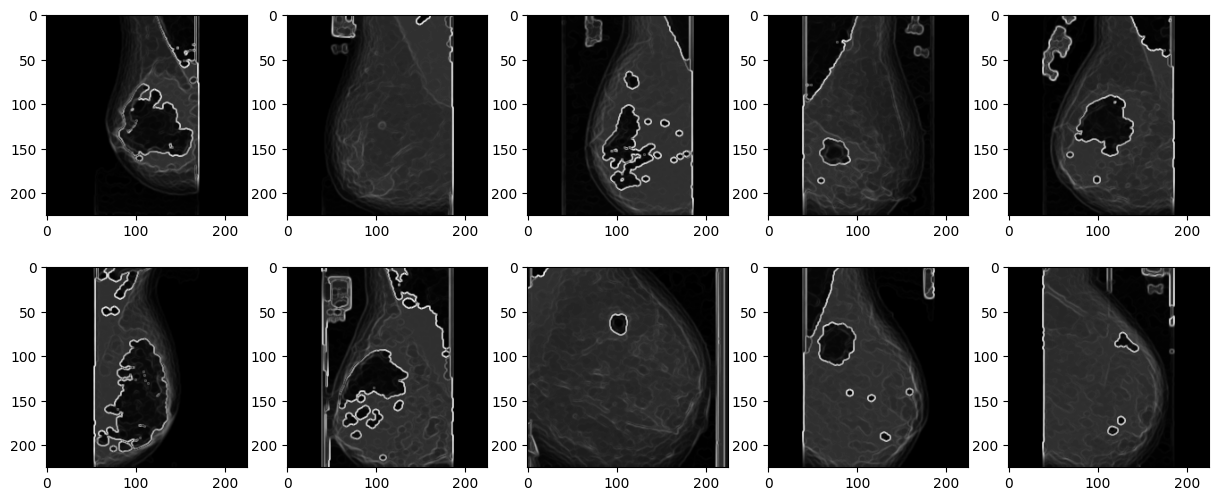

In [1411]:
imgs_sobel1 = apply_sobel_filter(imgs_close)
show_imgs(imgs_sobel1)


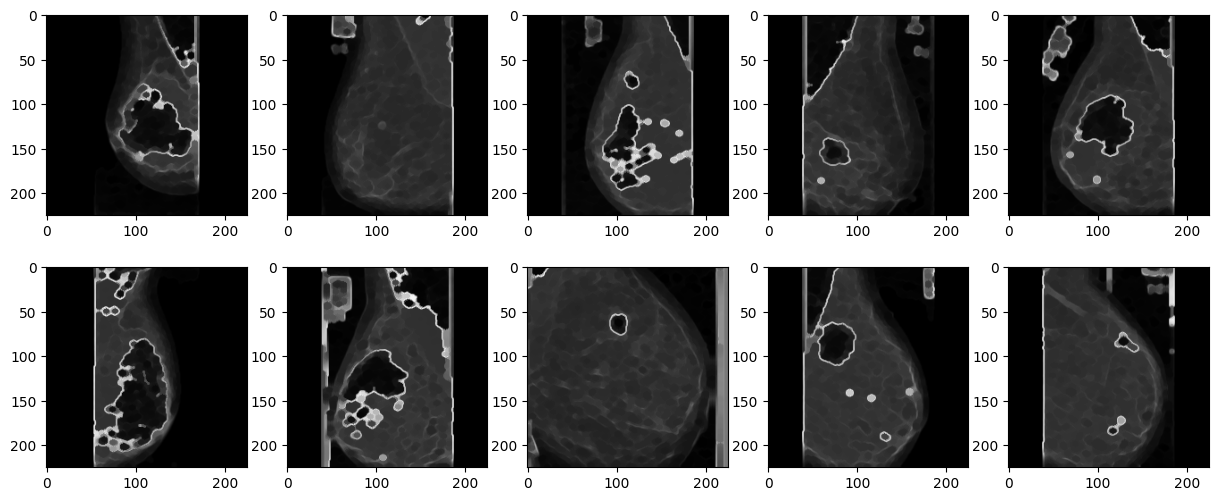

In [1412]:
imgs_close2 = apply_close_morfology(imgs_sobel1,(7,7))
show_imgs(imgs_close2)

# Umbralizacion

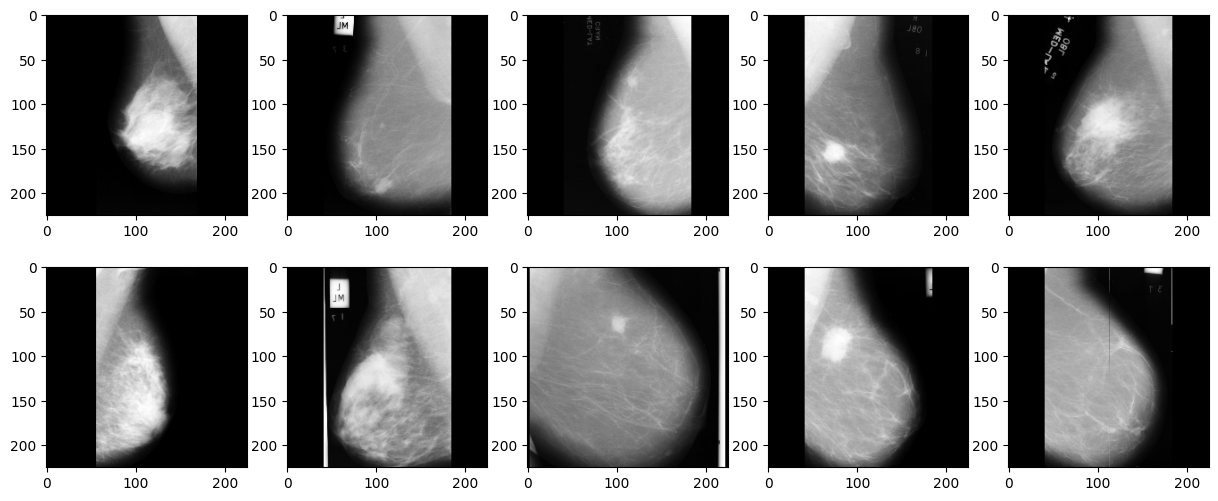

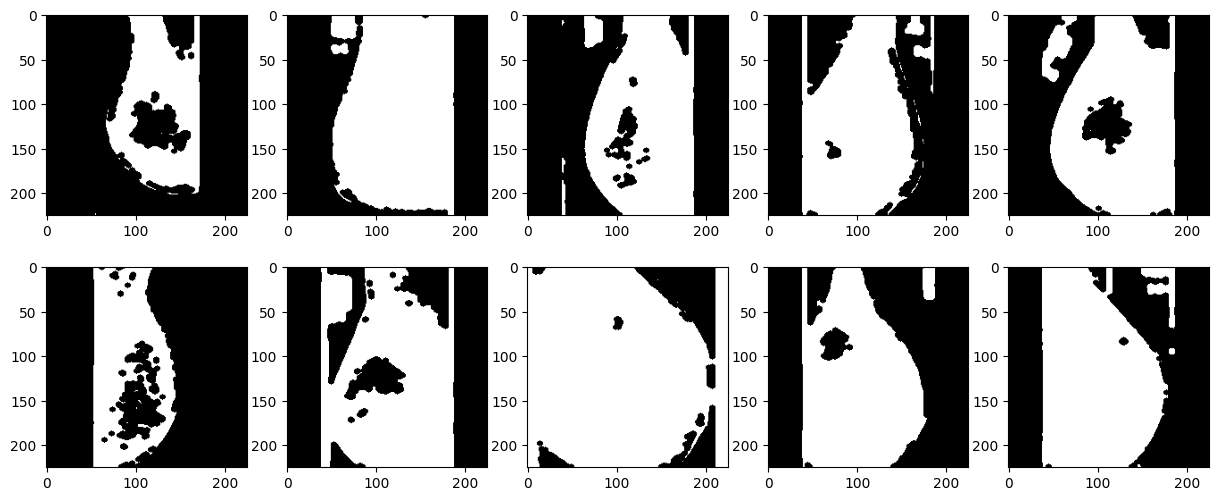

In [1413]:

def apply_global_threshold(imgs, threshold=127):
    # Aplicar umbralización global
    imgs_tresh = []
    for img in imgs:
        ret, thresh_img = cv2.threshold(img, threshold, 255, cv2.THRESH_BINARY)
        imgs_tresh.append(thresh_img)
    return imgs_tresh
    
# Aplicar umbralización global con un umbral de 127
thresholded_image = apply_global_threshold(imgs_close2, 127)

show_imgs(imgs)
show_imgs(thresholded_image)